In [67]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import glob

#https://colab.research.google.com/github/JeroenMulkers/mumax3-tutorial/blob/master/postprocessing.ipynb#scrollTo=apKunwIp0s6_
def read_mumax3_ovffiles(outputdir):
    from subprocess import run, PIPE, STDOUT
    from glob import glob
    from os import path
    from numpy import load

    fields = {}
    for npyfile in glob(outputdir+"/*.npy"):
        key = path.splitext(path.basename(npyfile))[0]
        fields[key] = load(npyfile)
    
    return fields

def getNameVal(name,val):
    i=name.index(val)
    start=i+1
    end=name[start:].index(";")+1
    return name[start:end]

runs=[]
for folder in glob.glob("pointinessdata/*.out"):
    filename=folder.split("\\")[-1]
    files=read_mumax3_ovffiles(folder)
    snapshots=[files[fileName] for fileName in sorted(files.keys())]
    m = np.stack(snapshots)

    print(getNameVal(filename,"p"))
    pointiness=float(getNameVal(filename,"p"))

    runs.append({
        "data":m,
        "pointiness":pointiness
    })




0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
0
1


In [152]:
for run in runs:
    run["dt"]=20e-12


XCOMPONENT=0
YCOMPONENT=1
ZCENTER=2

def getFFT(run):
    n=len(run["data"])
    m=run["data"]

    height=len(m[0][0][0])
    width=len(m[0][0][0][0])

    freqs=np.fft.fftfreq(n,run["dt"])[:n//2]
    fft=np.zeros((height,width,2,len(freqs)),dtype=np.float64)

    for y in range(height):
        for x in range(width):
            if m[0,0,0,y,x]==0 and m[0,1,0,y,x]==0:
                continue
                pass
            xData=m[:,XCOMPONENT,ZCENTER,y,x]
            yData=m[:,YCOMPONENT,ZCENTER,y,x]

            xFFT=np.fft.fft(xData)[:n//2]
            yFFT=np.fft.fft(yData)[:n//2]
            fft[y][x]=[xFFT,yFFT]
    return freqs,fft

for run in runs:
    
    freqs,fft=getFFT(run)
    run["fft"]=fft
    run["freqs"]=freqs

    



C:\Users\Schif\AppData\Local\Temp\ipykernel_32720\2694668513.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  fft[y][x]=[xFFT,yFFT]


In [164]:
from scipy.signal import find_peaks

XCOMPONENT=0
YCOMPONENT=1
ZCENTER=2

for run in runs:
    m=run["data"]

    height=len(m[0][0][0])
    width=len(m[0][0][0][0])

    allExtrema=set()
    overallFFTX=np.zeros(len(run["fft"][0][0][XCOMPONENT]))
    for y in range(height):
        for x in range(width):
            extrema,_=find_peaks(np.abs(run["fft"][y][x][XCOMPONENT]),prominence=1e-6)
            
            allExtrema=allExtrema.union(extrema)

            overallFFTX+=np.abs(run["fft"][y][x][XCOMPONENT])

    
    run["overallFFTX"]=overallFFTX
    run["peakFreqI"]=sorted(list(allExtrema))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 150, 155, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 2

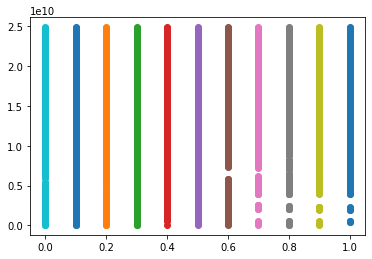

In [166]:

for run in runs:
    print(run["peakFreqI"])
    plt.plot([run["pointiness"]]*len(run["peakFreqI"]),run["freqs"][run["peakFreqI"]],"o")